In [4]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import Network
import networkx as nx
from external_world import ExternalWorld, MNISTExternalWorld

def plot_network_structure(net: Network):
    G = nx.DiGraph()
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    # Add nodes explicitly with subset attribute
    for layer_idx, layer_label in enumerate(layer_labels):
        layer_size = net.weights[0].shape[0] if layer_idx == 0 else net.weights[layer_idx - 1].shape[1]
        for neuron_idx in range(layer_size):
            G.add_node((layer_label, neuron_idx), subset=layer_idx)

    # Add edges
    for idx, W in enumerate(net.weights):
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                G.add_edge((layer_labels[idx], i), (layer_labels[idx + 1], j))

    pos = nx.multipartite_layout(G)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_size=50, arrowsize=5)
    plt.title("Network Structure")
    plt.show()

def plot_network_weights(net: Network, epoch):
    G = nx.DiGraph()
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    for i, layer_size in enumerate([net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]):
        for n in range(layer_size):
            G.add_node((layer_labels[i], n), subset=i)

    for idx, W in enumerate(net.weights):
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                weight = W[i, j].item()
                G.add_edge((layer_labels[idx], i), (layer_labels[idx+1], j), weight=weight)

    pos = nx.multipartite_layout(G, subset_key='subset')
    edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

    plt.figure(figsize=(5, 2))
    
    # Normalize edge colors and explicitly create a ScalarMappable
    norm = plt.Normalize(vmin=-np.max(np.abs(edge_weights)), vmax=np.max(np.abs(edge_weights)))
    cmap = plt.cm.RdYlGn

    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_weights, edge_cmap=cmap, edge_vmin=norm.vmin, edge_vmax=norm.vmax, arrowsize=10)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='gray')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(edge_weights)
    plt.colorbar(sm, label='Weight magnitude', ax = plt.gca())

    plt.title(f"Network Structure at Epoch {epoch}")
    plt.axis('off')
    plt.show()


def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 5, dtype=int)
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
        for epoch in range(epochs):
            for i in range(n_batches):
                net.update_mini_batch_index(i)
                net.negative_phase(n_it_neg)
                net.positive_phase(n_it_pos, *alphas)

            # Measure and log
            E, C, error = net.measure()
            history["Energy"].append(E)
            history["Cost"].append(C)
            history["Error"].append(error * 100)

            # Update progress bar description instead of using set_postfix()
            epoch_bar.set_description(f"Epoch {epoch+1}/{epochs} | E={E:.2f} C={C:.5f} Error={error*100:.2f}%")
            epoch_bar.update(1)
            if(plot_graph):
                if epoch in snapshot_epochs:
                    plot_network_weights(net, epoch)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
        ax.plot(history[key], label=key, color=color)
        ax.set_title(f"{key} over Epochs")
    plt.tight_layout()
    plt.show()

Epoch 20/20 | E=10.59 C=0.00076 Error=0.00%: 100%|██████████| 20/20 [00:34<00:00,  1.72s/epoch]


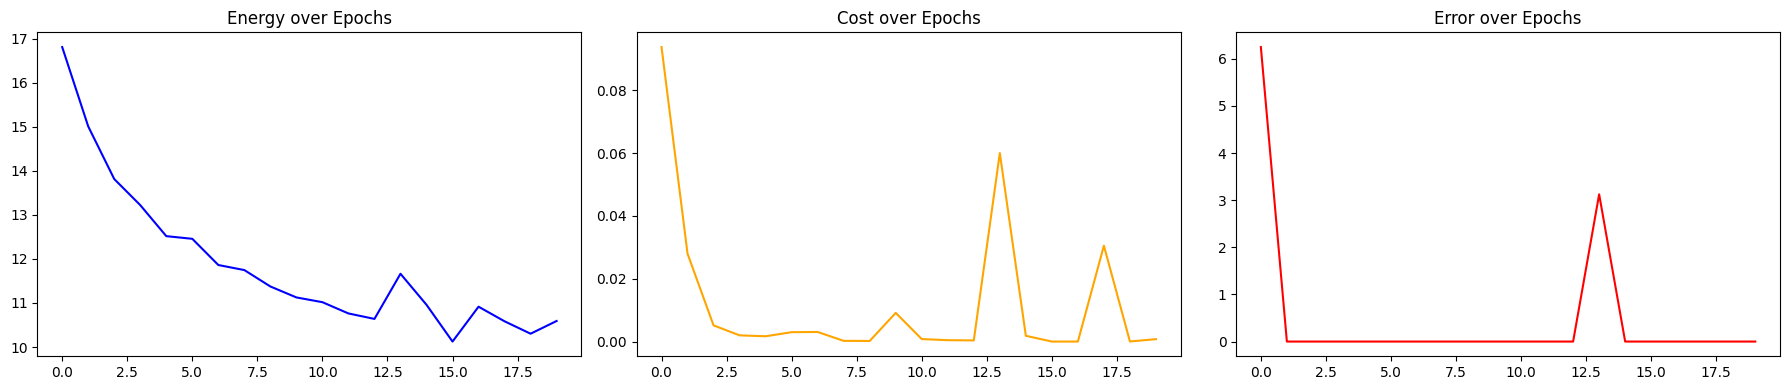

In [5]:
net=Network(
        name="mnist", 
        external_world=MNISTExternalWorld(), 
        hyperparameters={
            "hidden_sizes": [256],
            "n_epochs": 20,
            "batch_size": 32,
            "n_it_neg": 10,
            "n_it_pos": 10,
            "alphas": [np.float32(0.4), np.float32(0.1), np.float32(0.008)],
            "output_size": 10
        }
    )
train_net(net)

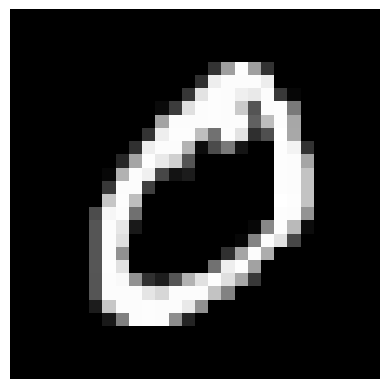

In [6]:
from wrappers import EnergyFunctionGenerator
import gzip
import pickle

with gzip.open("mnist.pkl.gz", "rb") as f:
    mnist_data = pickle.load(f, encoding="latin1")  # Use "latin1" for Python 3 compatibility
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = mnist_data

wrap = EnergyFunctionGenerator(net)

image = train_images[1]
energy_fn = wrap.input_clamped_energy_fn(torch.tensor(image, dtype=torch.float32).unsqueeze(0))
plt.imshow(image.reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()


In [21]:
num_free = sum(wrap.network_sizes[1:])
input = torch.zeros((1,num_free), requires_grad=True)

# Set Langevin parameters
eta = 0.1  # Step size (learning rate)
tau = 0.01   # Temperature (controls noise)
num_steps = 1000  # Number of Langevin steps

# Langevin sampling loop
for step in range(num_steps):
    # Compute energy value and gradients
    val = energy_fn(input)
    grad_s = torch.autograd.grad(val, input, create_graph=True)[0]

    # Add noise term (Gaussian noise with zero mean)
    noise = torch.randn_like(input) * torch.sqrt(torch.tensor(2 * eta * tau))

    # Langevin update: input -= eta * grad_s + noise
    input.data -= eta * grad_s + noise  # Perform update in-place

    # Optional: print energy every few steps for monitoring
    if step % 100 == 0:
        print(f"Step {step}, Energy: {val.item()}")


Step 0, Energy: 51.501014709472656
Step 100, Energy: -3044988.5
Step 200, Energy: -1390521614336.0
Step 300, Energy: -7.077513054723768e+17
Step 400, Energy: -3.686815269735537e+23
Step 500, Energy: -1.931109014474874e+29
Step 600, Energy: -1.0129162121123667e+35
Step 700, Energy: nan
Step 800, Energy: nan
Step 900, Energy: nan


In [20]:
print(input)

tensor([[ 1.9483e+01,  2.5655e+02,  9.3291e+01, -7.5781e+01, -8.5063e+01,
         -1.6149e+02,  4.0472e+01,  3.2521e+01, -8.2695e+01, -2.9354e+01,
          6.1444e+00, -1.2722e+02, -2.0278e+01,  1.8803e+01,  8.7277e+01,
         -1.0481e+02,  4.0991e+01,  1.7441e+02, -3.0054e+02, -2.4992e+01,
          2.9533e+01, -6.5318e+01,  3.0737e+01, -7.9890e+01,  1.4856e+02,
          1.6090e+02,  2.5360e+01,  9.1427e+00, -8.2111e+01, -1.9941e+00,
          1.1015e+01, -1.6350e+02,  3.3086e+01, -1.7885e+02, -1.2509e+02,
         -1.1758e+02,  4.7783e+01,  3.2022e+02, -1.9367e+02, -1.2292e+02,
         -7.9936e+01,  5.5865e+01, -2.3176e+02,  1.3854e+02,  1.3372e+02,
         -3.9534e+01,  5.1639e+01, -2.4925e+02, -3.0392e+02,  1.4611e+02,
          2.6821e+02, -2.0072e+02, -2.1513e+02, -1.0001e+02,  3.6002e+02,
         -2.5849e+02, -7.3286e+01,  1.1547e+02,  5.9934e+01, -1.3455e+02,
          1.6495e+02, -1.7201e+02,  7.7987e+01,  4.0353e+00,  9.0010e+01,
         -2.2142e+01, -1.0266e+02, -1.